copy from https://github.com/dipanjanS/data_science_for_all/blob/master/gde_tf_serve_vision/tensorflow_serving/Model_Training_Prototypes.ipynb

# Load Dependencies 

In [1]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import shutil
import requests
from tqdm import tqdm

tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

%matplotlib inline

1.14.0


# Load Dataset
Here we will leverage an out of the box dataset since the intent of this tutorial is to showcase model serving more than model architecture, training and evaluation. However we will cover these steps also to a good extent.

## The Fashion-MNIST Dataset

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Here's an example how the data looks (each class takes three-rows):

<table>
  <tr><td>
    <img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow.

__Note:__ Although these are really images, they are loaded as NumPy arrays and not binary image objects.

## Loading the Fashion-MNIST Dataset

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


## Reshaping Image Data for Modeling

In [3]:
# reshape for feeding into the model
train_images_gr = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 28, 28, 1)

print('\nTrain_images.shape: {}, of {}'.format(train_images_gr.shape, train_images_gr.dtype))
print('Test_images.shape: {}, of {}'.format(test_images_gr.shape, test_images_gr.dtype))


Train_images.shape: (60000, 28, 28, 1), of uint8
Test_images.shape: (10000, 28, 28, 1), of uint8


['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


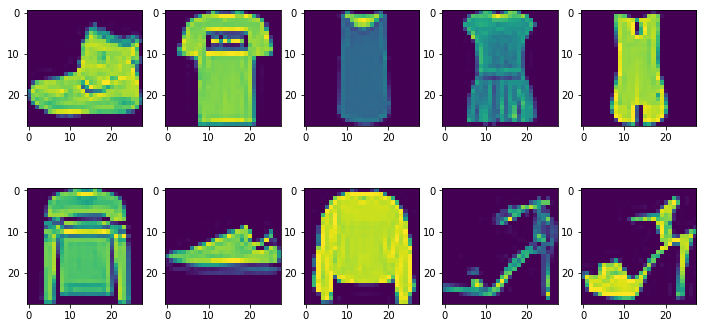

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
ax[0, 0].imshow(train_images_gr[0].reshape(28,28))
ax[0, 1].imshow(train_images_gr[1].reshape(28,28))
ax[0, 2].imshow(train_images_gr[2].reshape(28,28))
ax[0, 3].imshow(train_images_gr[3].reshape(28,28))
ax[0, 4].imshow(train_images_gr[4].reshape(28,28))
ax[1, 0].imshow(train_images_gr[5].reshape(28,28))
ax[1, 1].imshow(train_images_gr[6].reshape(28,28))
ax[1, 2].imshow(train_images_gr[7].reshape(28,28))
ax[1, 3].imshow(train_images_gr[8].reshape(28,28))
ax[1, 4].imshow(train_images_gr[9].reshape(28,28))

print([class_names[i] for i in train_labels[:10]])

# Model Training and Evaluation

In this section we will focus on building, training and evaluating two different deep learning models, one based on a simple CNN architecture and one based on a complex, pre-trained CNN model

## Model 1: Basic CNN from Scratch

In [5]:
INPUT_SHAPE = (28, 28, 1)

def create_cnn_architecture_model1(input_shape):
    inp = keras.layers.Input(shape=input_shape)

    conv1 = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='same')(inp)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                   activation='relu', padding='same')(pool1)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    flat = keras.layers.Flatten()(pool2)

    hidden1 = keras.layers.Dense(256, activation='relu')(flat)
    drop1 = keras.layers.Dropout(rate=0.3)(hidden1)

    out = keras.layers.Dense(10, activation='softmax')(drop1)

    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    return model

In [6]:
model = create_cnn_architecture_model1(input_shape=INPUT_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               401664

In [7]:
EPOCHS = 10
train_images_scaled = train_images_gr / 255.
model.fit(train_images_scaled, train_labels, validation_split=0.1, epochs=EPOCHS)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 8s 150us/sample - loss: 0.4521 - acc: 0.8369 - val_loss: 0.3171 - val_acc: 0.8795
Epoch 2/10
54000/54000 [==============================] - 8s 150us/sample - loss: 0.3020 - acc: 0.8903 - val_loss: 0.2618 - val_acc: 0.9025
Epoch 3/10
54000/54000 [==============================] - 8s 149us/sample - loss: 0.2576 - acc: 0.9047 - val_loss: 0.2581 - val_acc: 0.9063
Epoch 4/10
54000/54000 [==============================] - 8s 150us/sample - loss: 0.2260 - acc: 0.9158 - val_loss: 0.2354 - val_acc: 0.9098
Epoch 5/10
54000/54000 [==============================] - 8s 154us/sample - loss: 0.2040 - acc: 0.9239 - val_loss: 0.2288 - val_acc: 0.9137
Epoch 6/10
54000/54000 [==============================] - 8s 148us/sample - loss: 0.1817 - acc: 0.9324 - val_loss: 0.2226 - val_acc: 0.9188
Epoch 7/10
54000/54000 [==============================] - 8s 153us/sample - loss: 0.1640 - acc: 0.9391 - val_lo

In [8]:
import os

if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
    
model.save_weights(filepath='model_weights/cnn_model1_wt.h5', overwrite=True)

In [9]:
model = create_cnn_architecture_model1(input_shape=INPUT_SHAPE)
model.load_weights('model_weights/cnn_model1_wt.h5')

In [10]:
test_images_scaled = test_images_gr / 255.
predictions = model.predict(test_images_scaled)
predictions[:5]

array([[2.0170397e-08, 5.2192144e-12, 7.2691436e-11, 4.6580300e-12,
        4.9182368e-12, 2.6563310e-07, 1.1300574e-11, 9.6405602e-06,
        6.4889157e-12, 9.9999011e-01],
       [2.8658576e-08, 2.2350158e-16, 1.0000000e+00, 1.2000848e-11,
        7.0279103e-09, 6.7357182e-16, 1.4765401e-08, 7.1670211e-15,
        7.1164640e-13, 5.5230482e-17],
       [4.0327339e-13, 1.0000000e+00, 6.3692299e-15, 9.8238631e-12,
        3.6894370e-14, 8.2893026e-18, 1.2897783e-16, 6.9791224e-25,
        3.2574785e-16, 2.4740956e-25],
       [5.3311270e-12, 1.0000000e+00, 7.7960113e-14, 3.1121750e-09,
        3.3359576e-11, 1.2423755e-16, 7.8270317e-14, 4.8535796e-21,
        5.6089992e-16, 4.1682458e-20],
       [2.4044771e-01, 3.1726757e-10, 2.3485781e-03, 3.3318451e-05,
        3.8505951e-04, 3.5979340e-09, 7.5678527e-01, 9.1170511e-09,
        7.2509398e-09, 8.7526658e-08]], dtype=float32)

In [11]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([9, 2, 1, 1, 6])

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print(classification_report(test_labels, prediction_labels, target_names=class_names))
pd.DataFrame(confusion_matrix(test_labels, prediction_labels), index=class_names, columns=class_names)

             precision    recall  f1-score   support

T-shirt/top       0.89      0.84      0.87      1000
    Trouser       1.00      0.98      0.99      1000
   Pullover       0.90      0.85      0.88      1000
      Dress       0.87      0.96      0.92      1000
       Coat       0.89      0.86      0.87      1000
     Sandal       0.99      0.98      0.99      1000
      Shirt       0.75      0.80      0.77      1000
    Sneaker       0.94      0.98      0.96      1000
        Bag       0.98      0.98      0.98      1000
 Ankle boot       0.98      0.96      0.97      1000

avg / total       0.92      0.92      0.92     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,843,1,10,21,3,0,115,0,7,0
Trouser,1,978,1,15,1,0,3,0,1,0
Pullover,13,0,853,13,51,0,70,0,0,0
Dress,8,0,8,963,8,0,10,0,3,0
Coat,1,0,33,39,861,0,65,0,1,0
Sandal,0,0,0,0,0,977,0,21,0,2
Shirt,75,0,38,40,43,0,796,0,8,0
Sneaker,0,0,0,0,0,2,0,983,0,15
Bag,3,0,0,10,2,1,2,3,979,0
Ankle boot,0,0,0,0,0,3,1,35,0,961


In [13]:
model1 = create_cnn_architecture_model1(input_shape=INPUT_SHAPE)
model1.load_weights('./model_weights/cnn_model1_wt.h5')
export_path = './tf_saved_models/1'
if os.path.isdir(export_path):
    shutil.rmtree(export_path, ignore_errors=True)

# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors
# And stored with the default serving key
tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs={'input_image': model1.input},
    outputs={t.name:t for t in model1.outputs})

In [14]:
! tree --du -h .

.
├── [1.9K]  app.py
├── [ 257]  models.conf
├── [ 54K]  Model_Training_Prototypes.ipynb
├── [1.6M]  model_weights
│   └── [1.6M]  cnn_model1_wt.h5
├── [4.0K]  nohup.out
├── [1.1M]  server.log
├── [ 44K]  sneaker.jpg
└── [8.0M]  tf_saved_models
    └── [8.0M]  1
        ├── [178K]  saved_model.pb
        └── [7.8M]  variables
            ├── [7.8M]  variables.data-00000-of-00001
            └── [1.6K]  variables.index

  11M used in 4 directories, 10 files


---

# launch  tensorflow-serving with docker

In [15]:
!docker pull tensorflow/serving:latest

latest: Pulling from tensorflow/serving
Digest: sha256:f7e59a29cbc17a6b507751cddde37bccad4407c05ebf2c13b8e6ccb7d2e9affb
Status: Image is up to date for tensorflow/serving:latest
docker.io/tensorflow/serving:latest


In [16]:
!docker images

REPOSITORY           TAG                 IMAGE ID            CREATED             SIZE
todoapp              latest              ab5b6ffd7eb7        2 months ago        958MB
node                 latest              7c412a558705        2 months ago        907MB
tensorflow/serving   latest-gpu          b247542eae94        2 months ago        2.42GB
tensorflow/serving   latest              d4b221a3f345        2 months ago        220MB
hello-world          latest              fce289e99eb9        8 months ago        1.84kB


In [17]:
%%bash --bg 
docker run -p 8501:8501 \
  --mount type=bind,source=/home/jupyter/tensorflow_serving_docker/tf_saved_models,\
target=/home/jupyter/tensorflow_serving/tf_saved_models \
  --mount type=bind,source=/home/jupyter/tensorflow_serving_docker/models.conf,\
target=/home/jupyter/tensorflow_serving/models.conf \
  -t tensorflow/serving:latest --model_config_file=/home/jupyter/tensorflow_serving/models.conf

In [18]:
!docker ps -all

CONTAINER ID        IMAGE                       COMMAND                  CREATED             STATUS                  PORTS                              NAMES
ad3781e33284        tensorflow/serving:latest   "/usr/bin/tf_serving…"   1 second ago        Up Less than a second   8500/tcp, 0.0.0.0:8501->8501/tcp   sharp_austin


In [19]:
!docker logs ad3781e33284 | tail -n 15

In [20]:
!cat models.conf

model_config_list: {
  config: {
    name:  "fashion_model_serving",
    base_path:  "/home/jupyter/tensorflow_serving/tf_saved_models",
    model_platform: "tensorflow",
    model_version_policy {
      specific {
        versions: 1
      }
    }
  }
}




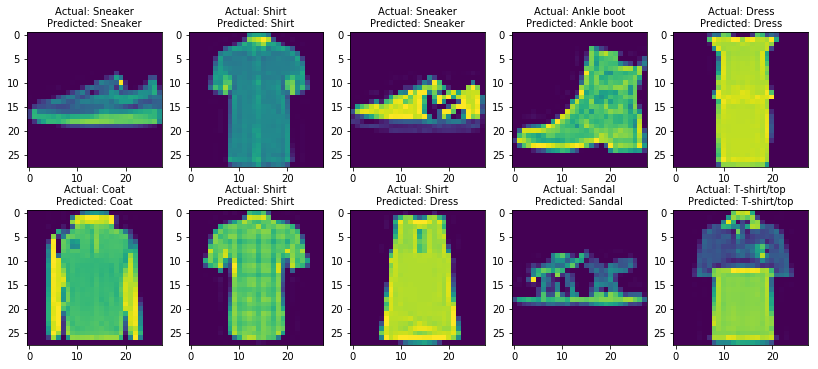

In [21]:
sample_test_data = test_images[580:590]
sample_test_labels = test_labels[580:590]
sample_test_data_processed = np.expand_dims(sample_test_data / 255., axis=3)
data = json.dumps({"signature_name": "serving_default", 
                   "instances": sample_test_data_processed.tolist()})

HEADERS = {'content-type': 'application/json'}
MODEL1_API_URL = 'http://localhost:8501/v1/models/fashion_model_serving/versions/1:predict'

json_response = requests.post(MODEL1_API_URL, data=data, headers=HEADERS)
predictions = json.loads(json_response.text)['predictions']
predictions = np.argmax(np.array(predictions), axis=1)
prediction_labels = [class_names[p] for p in predictions]

fig, ax = plt.subplots(2, 5, figsize=(14, 6))
for idx, img in enumerate(sample_test_data):
    rowidx = idx // 5
    colidx = idx % 5
    ax[rowidx, colidx].imshow(img)
    ax[rowidx, colidx].set_title('Actual: {}\nPredicted: {}'.format(class_names[sample_test_labels[idx]], 
                                                                    prediction_labels[idx]), fontsize=10)

# Building an Apparel Classifier API with Flask & TensorFlow Serving

In [22]:
%%bash --bg 
nohup python app.py >server.log 2>&1

In [23]:
r = requests.get('http://0.0.0.0:5000/apparel_classifier/api/v1/liveness')
r.status_code, r.text

(200, 'API Live!')

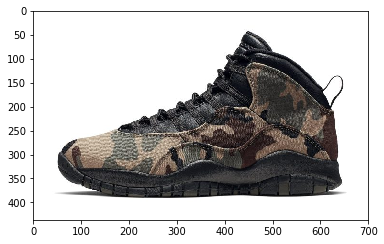

In [24]:
plt.imshow(cv2.cvtColor(cv2.imread('sneaker.jpg'), cv2.COLOR_BGR2RGB))

In [25]:
import base64
import requests 

with open('sneaker.jpg', "rb") as imageFile:
    img_b64enc = base64.b64encode(imageFile.read())
    data = {'b64_img': img_b64enc}

API_URL = 'http://0.0.0.0:5000/apparel_classifier/api/v1/model1_predict'
# sending post request and saving response as response object
r = requests.post(url=API_URL, data=data)
r.json()

{'apparel_type': 'Dress'}

In [26]:
%%time

responses = []
for i in tqdm(range(100)):
    API_URL = 'http://0.0.0.0:5000/apparel_classifier/api/v1/model1_predict'
    # sending post request and saving response as response object
    r = requests.post(url=API_URL, data=data)
    responses.append(r.json())
len(responses)

100%|██████████| 100/100 [00:01<00:00, 77.85it/s]

CPU times: user 393 ms, sys: 20.2 ms, total: 413 ms
Wall time: 1.29 s


100